In [1]:
import gym
import latex
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import random
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})


import matplotlib
matplotlib.rcParams['text.usetex'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.ticker import MaxNLocator

from collections import defaultdict

import gym
from gym import spaces
from gym.utils import seeding


/home/eskender/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Part 1

In [2]:
# Инициализация
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]



In [3]:
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

Наивная стратегия, берём карты, пока сумма очков меньше 19

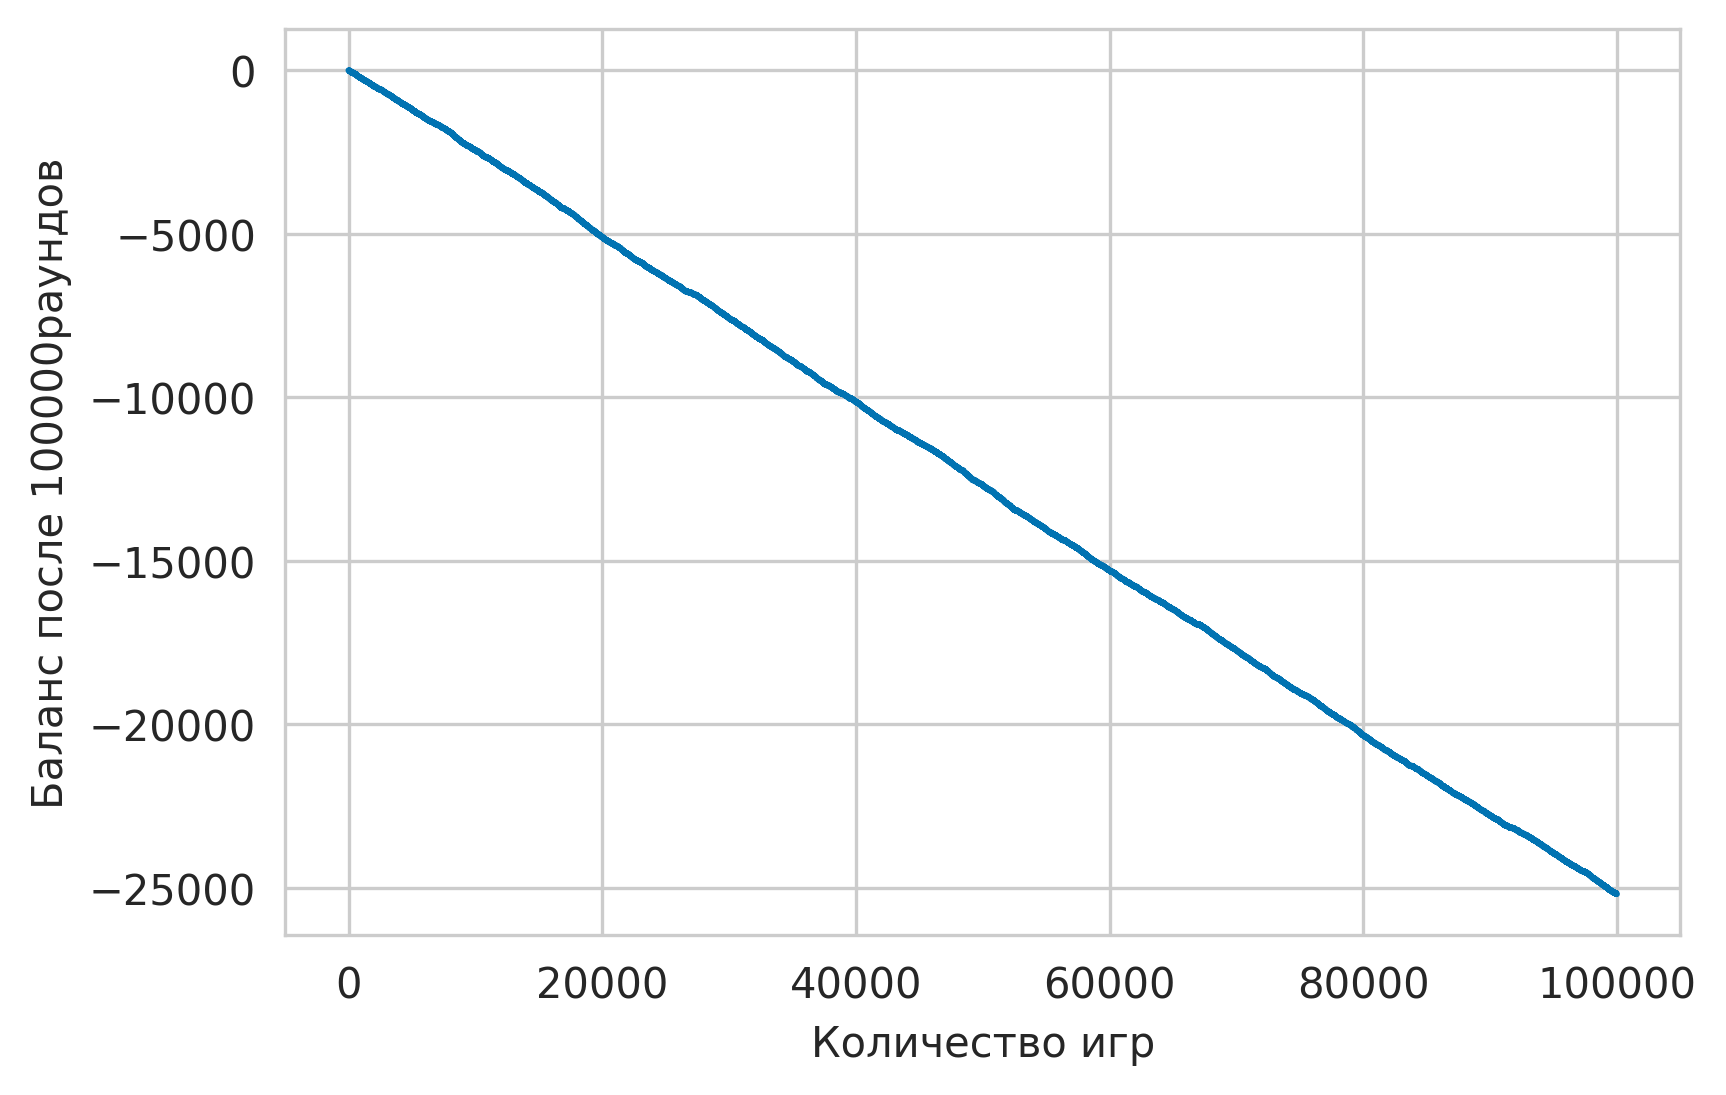

Средний баланс после  100000 раунда игры -25189.0

Средняя награда: -0.126597
Среднее число карт: 2.498270


In [4]:


def simple_strategy(num_experiments):
    
    for i in range(num_experiments):
        bj.reset()
        
        total_reward.append(0)
        total_points = 0

        cnt = 0
        while total_points < 19:

            state, reward, done, _ = bj.step(True)
            
            total_points = state[0]
            cnt += 1
            
        state, reward, done, _  = bj.step(False)
        
        total_reward[i] = total_reward[i - 1] 
        total_reward[i] += reward
        
        num_steps.append(cnt+1)

     

    
    
bj = BlackjackEnv()

num_steps, total_reward = [], []

num_experiments = 100000

simple_strategy(num_experiments)

plt.plot(total_reward)                
plt.xlabel('Количество игр')
plt.ylabel('Баланс после ' + str(num_experiments) + 'раундов')
plt.show()    
print ("Средний баланс после  {} раунда игры {}".format(num_experiments, total_reward[num_experiments-1]))

bj.close()

print("\nСредняя награда: %.6f\nСреднее число карт: %.6f" % (np.mean(total_reward)/num_experiments, np.mean(num_steps)))

In [5]:
bj = BlackjackEnv()

In [6]:
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):

    random_action = random.randint(0, action_size - 1)  
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

In [7]:
def monte_carlo(gamma=1., num_experiments=5000):

    Q = defaultdict(lambda: np.zeros(bj.action_space.n))

    state_count = defaultdict(float)
    state_action_count = defaultdict(float)

    evaluations = []

    for i in range(num_experiments):


        episode = []
    
        state = bj.reset()
        done = False
        
        total_reward.append(0)
        total_points = 0

        cnt = 0
        
        while total_points < 19:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], bj.action_space.n)

            new_state, reward, done, _ = bj.step(action=action)
        
            episode.append((state, action, reward))
        
            state = new_state
            
            total_points = state[0]
            cnt += 1
            
        state, reward, done, _  = bj.step(False)
        
        total_reward[i] = total_reward[i - 1] 
        total_reward[i] += reward
        
        num_steps.append(cnt+1)

        G = 0
    
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1

            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
            
    return Q


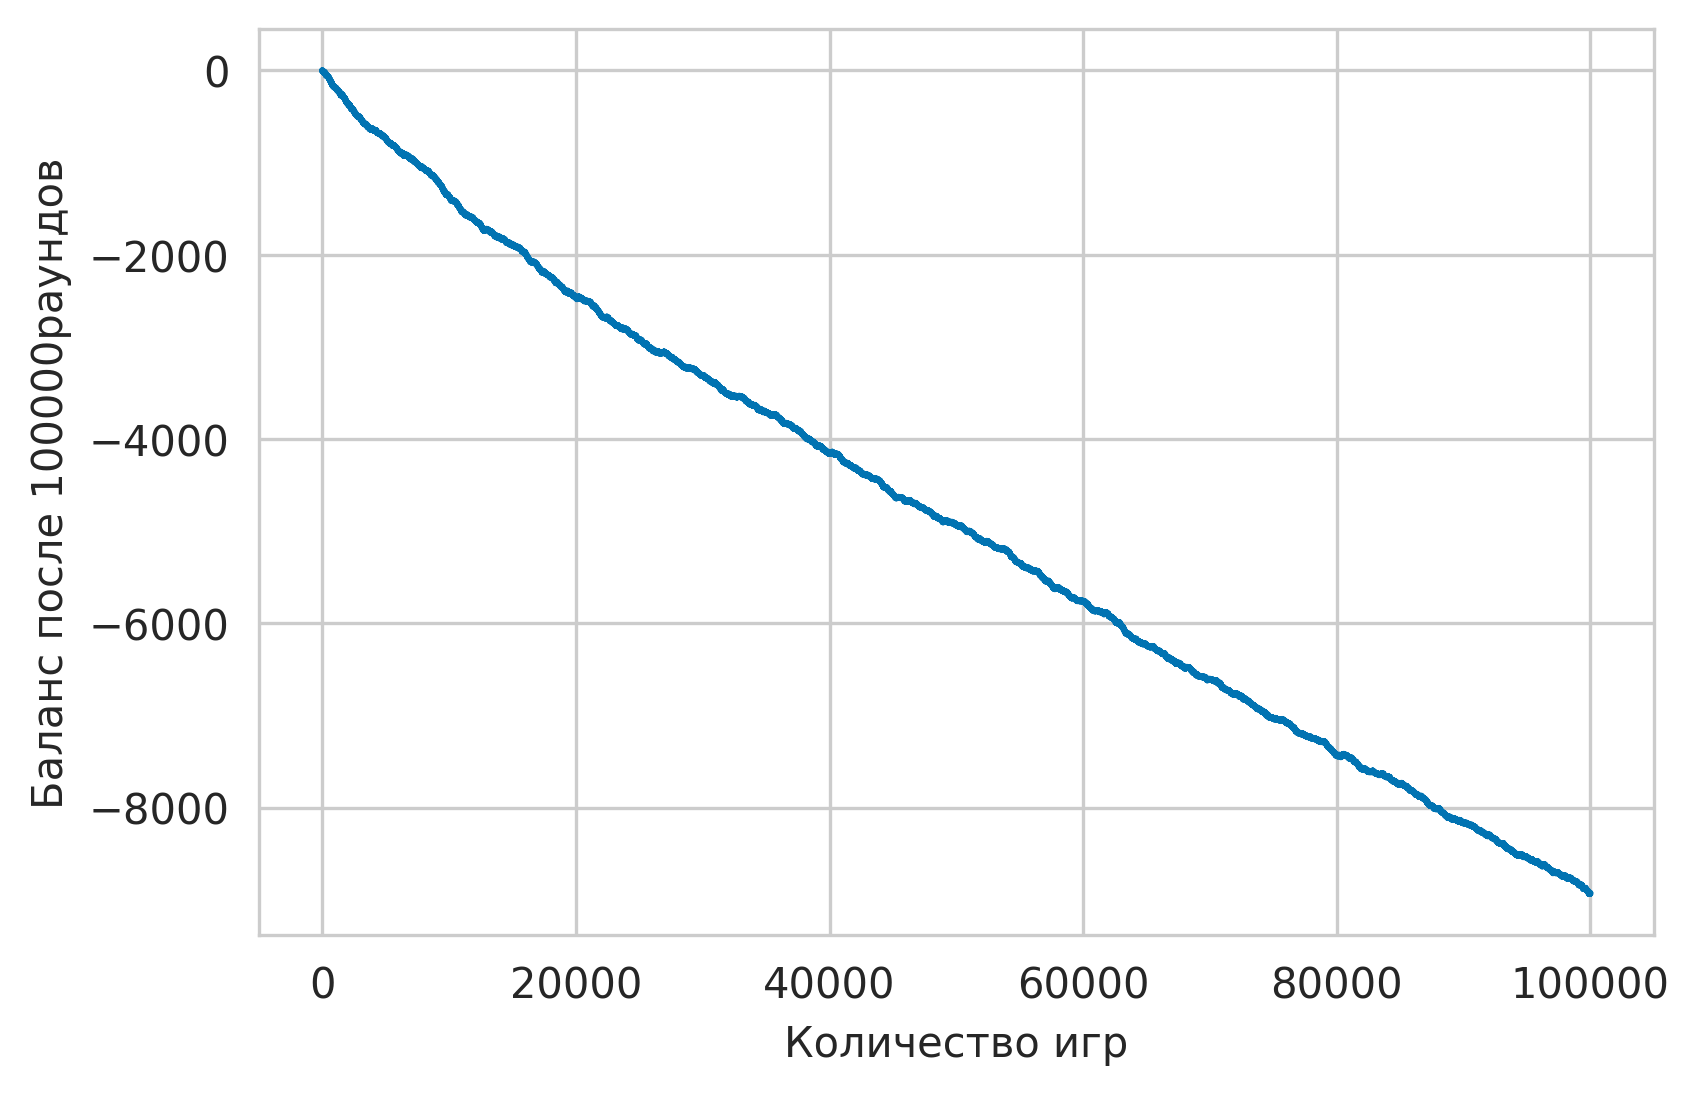

Средний баланс после  100000 раунда игры -8931.0

Средняя награда: -0.048707
Среднее число карт: 2.743840


In [8]:
num_steps, total_reward = [], []

num_experiments = 100000

Q_mc = monte_carlo(num_experiments=num_experiments)

plt.plot(total_reward)                
plt.xlabel('Количество игр')
plt.ylabel('Баланс после ' + str(num_experiments) + 'раундов')
plt.show()    
print ("Средний баланс после  {} раунда игры {}".format(num_experiments, total_reward[num_experiments-1]))

bj.close()

print("\nСредняя награда: %.6f\nСреднее число карт: %.6f" % (np.mean(total_reward)/num_experiments, np.mean(num_steps)))

## Part 2

реализация удвоения

In [9]:
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False, double=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        

        self.natural = natural
        
        self.double = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action, double):
        
        #print(action, double)
        assert self.action_space.contains(action)
        self.double = double
        
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                #print(self.double)
                if self.double:
                    
                    reward = -2.

                else:
                    reward = -1.
   
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and (reward == 1. | reward==2):
                if self.double:
                    reward = 1.5 *2

                else:
                    reward = 1 * 2

                    
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [10]:
del bj
bj = BlackjackEnv()

The vast majority of Blackjack strategies will recommend always doubling down if 
your first two cards have a value of 11.
This gives you an approximate 53.8% chance of finishing your turn with 
a strong hand containing a value of 18 or higher, 
and around a 30.4% probability of finishing it with a hand valued at 21.

https://www.pinnacle.com/en/betting-articles/casino/what-is-doubling-down-in-blackjack/RBQ2N53FK93PCT5P

реализовал удвоение, если на руках карты,. дающие в сумме 11


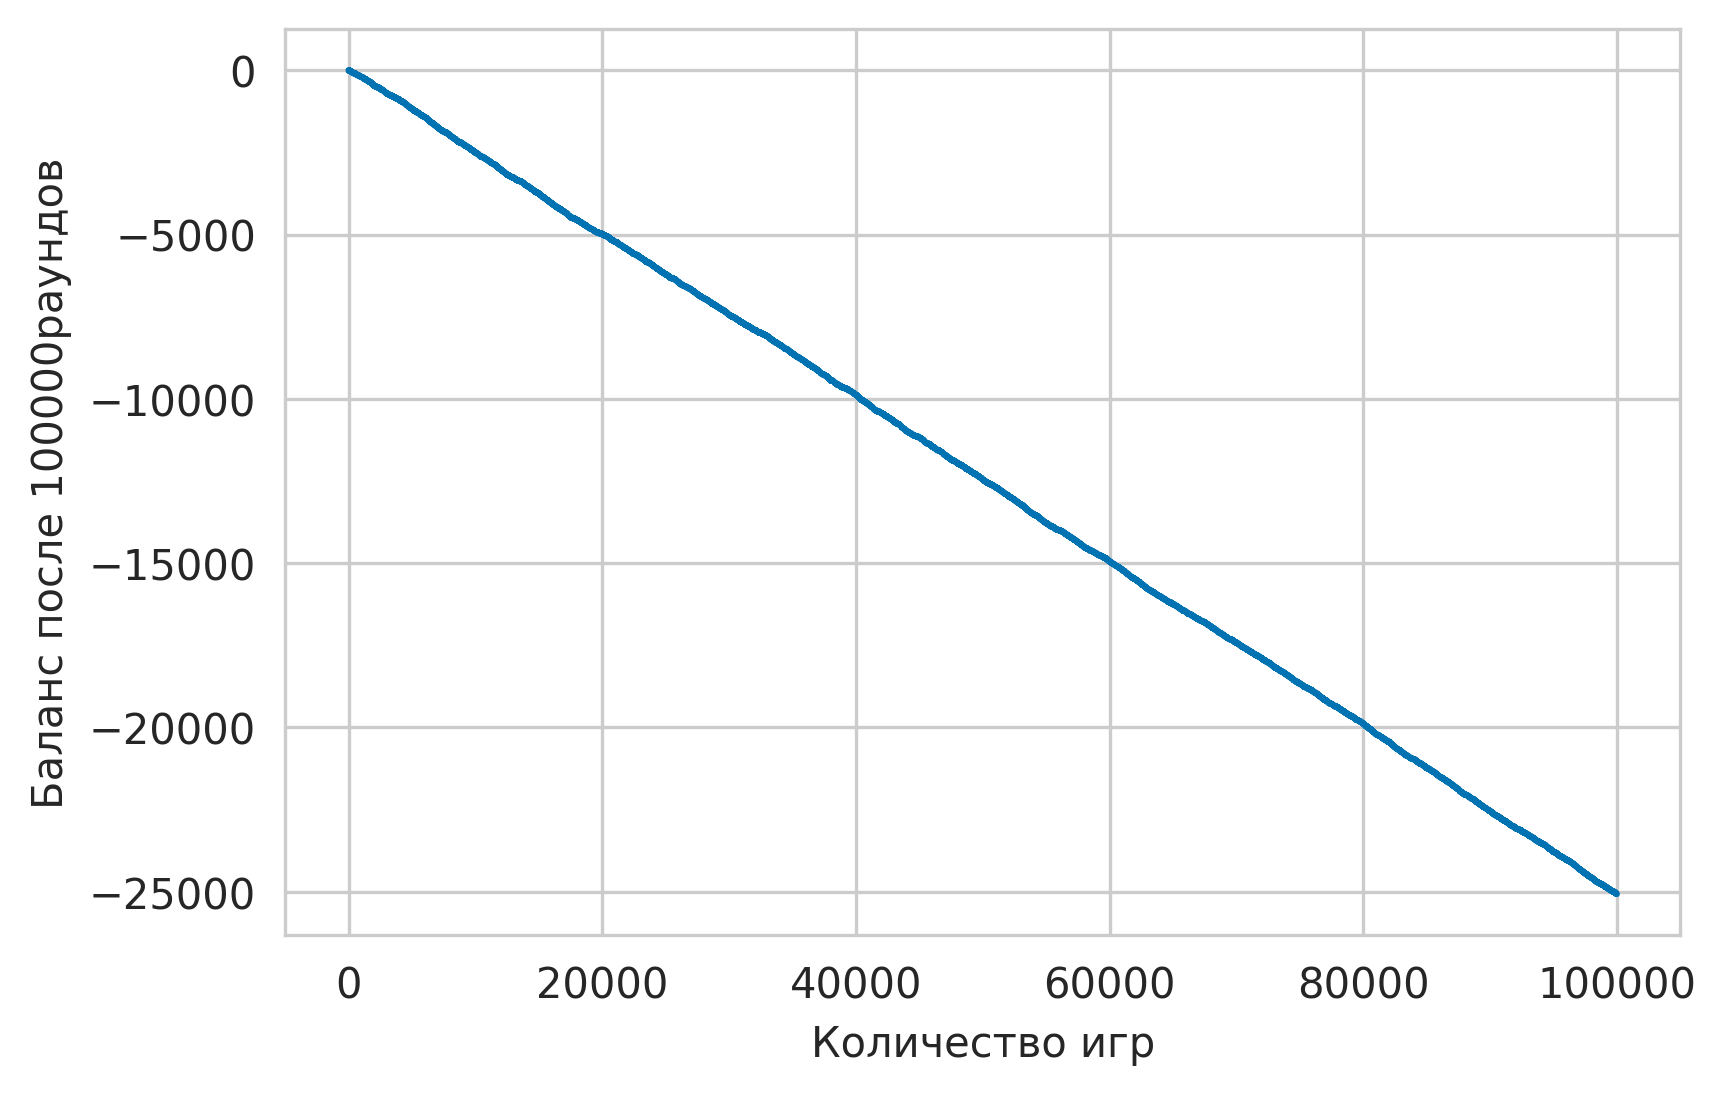

Средний баланс после  100000 раунда игры -25068.0

Средняя награда: -0.124618
Среднее число карт: 2.490570


In [11]:

def simple_strategy(num_experiments):
    
    for i in range(num_experiments):
        bj.reset()
        
        total_reward.append(0)
        total_points = 0

        cnt = 0
        
        wasnt_double = True
        
        while total_points < 19:
            
            if total_points ==11:
                
                
                state, reward, done, _ = bj.step(action = True, double = True)
                state, reward, done, _  = bj.step(action = False, double = True)
                total_reward[i] = total_reward[i - 1] 
                total_reward[i] += reward * 2
        
                wasnt_double = False
                cnt += 1
                break
            else:
                state, reward, done, _ = bj.step(action = True, double = False)
            
                total_points = state[0]
                cnt += 1

        if wasnt_double:
            state, reward, done, _  = bj.step(action = False, double = False)
        
            total_reward[i] = total_reward[i - 1] 
            total_reward[i] += reward
        
        num_steps.append(cnt+1)


        
        
        
bj = BlackjackEnv()

num_steps, total_reward = [], []

num_experiments = 100000

simple_strategy(num_experiments)

plt.plot(total_reward)                
plt.xlabel('Количество игр')
plt.ylabel('Баланс после ' + str(num_experiments) + 'раундов')
plt.show()    
print ("Средний баланс после  {} раунда игры {}".format(num_experiments, total_reward[num_experiments-1]))

bj.close()

print("\nСредняя награда: %.6f\nСреднее число карт: %.6f" % (np.mean(total_reward)/num_experiments, np.mean(num_steps)))

In [12]:
def monte_carlo(gamma=1., num_experiments=5000):

    Q = defaultdict(lambda: np.zeros(bj.action_space.n))

    state_count = defaultdict(float)
    state_action_count = defaultdict(float)


    for i in range(num_experiments):

        episode = []

        total_reward.append(0)
        total_points = 0
        
        wasnt_double = True
        cnt = 0 
        
        state = bj.reset()
        done = False
        
        while total_points < 19:
            if total_points ==11:
                
                state_count[state] += 1
                action = get_action(Q, state, state_count[state], bj.action_space.n)

                new_state, reward, done, _ = bj.step(action=action, double = True)
                total_points = new_state[0]
                
                new_state, reward, done, _ = bj.step(action=False, double = True)
                episode.append((state, action, reward))

                state = new_state
                
                
                
                total_reward[i] = total_reward[i - 1] 
                total_reward[i] += reward*2
                
                wasnt_double = False
                cnt += 1
                

                break
            else:
                state_count[state] += 1
                action = get_action(Q, state, state_count[state], bj.action_space.n)
                if action:
                    cnt += 1
                new_state, reward, done, _ = bj.step(action=action, double = True)
                
                total_points = new_state[0]
                
                

        if wasnt_double: 
            state, reward, done, _  = bj.step(action = False, double = False)
            
            total_points = new_state[0]
            
            total_reward[i] = total_reward[i - 1] 
            total_reward[i] += reward
            
            

        num_steps.append(cnt+1)


        G = 0
    
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1

            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
            
    return Q

In [13]:
bj = BlackjackEnv()
num_steps, total_reward = [], []

num_experiments = 10000


In [14]:
Q_mc = monte_carlo(num_experiments=num_experiments)

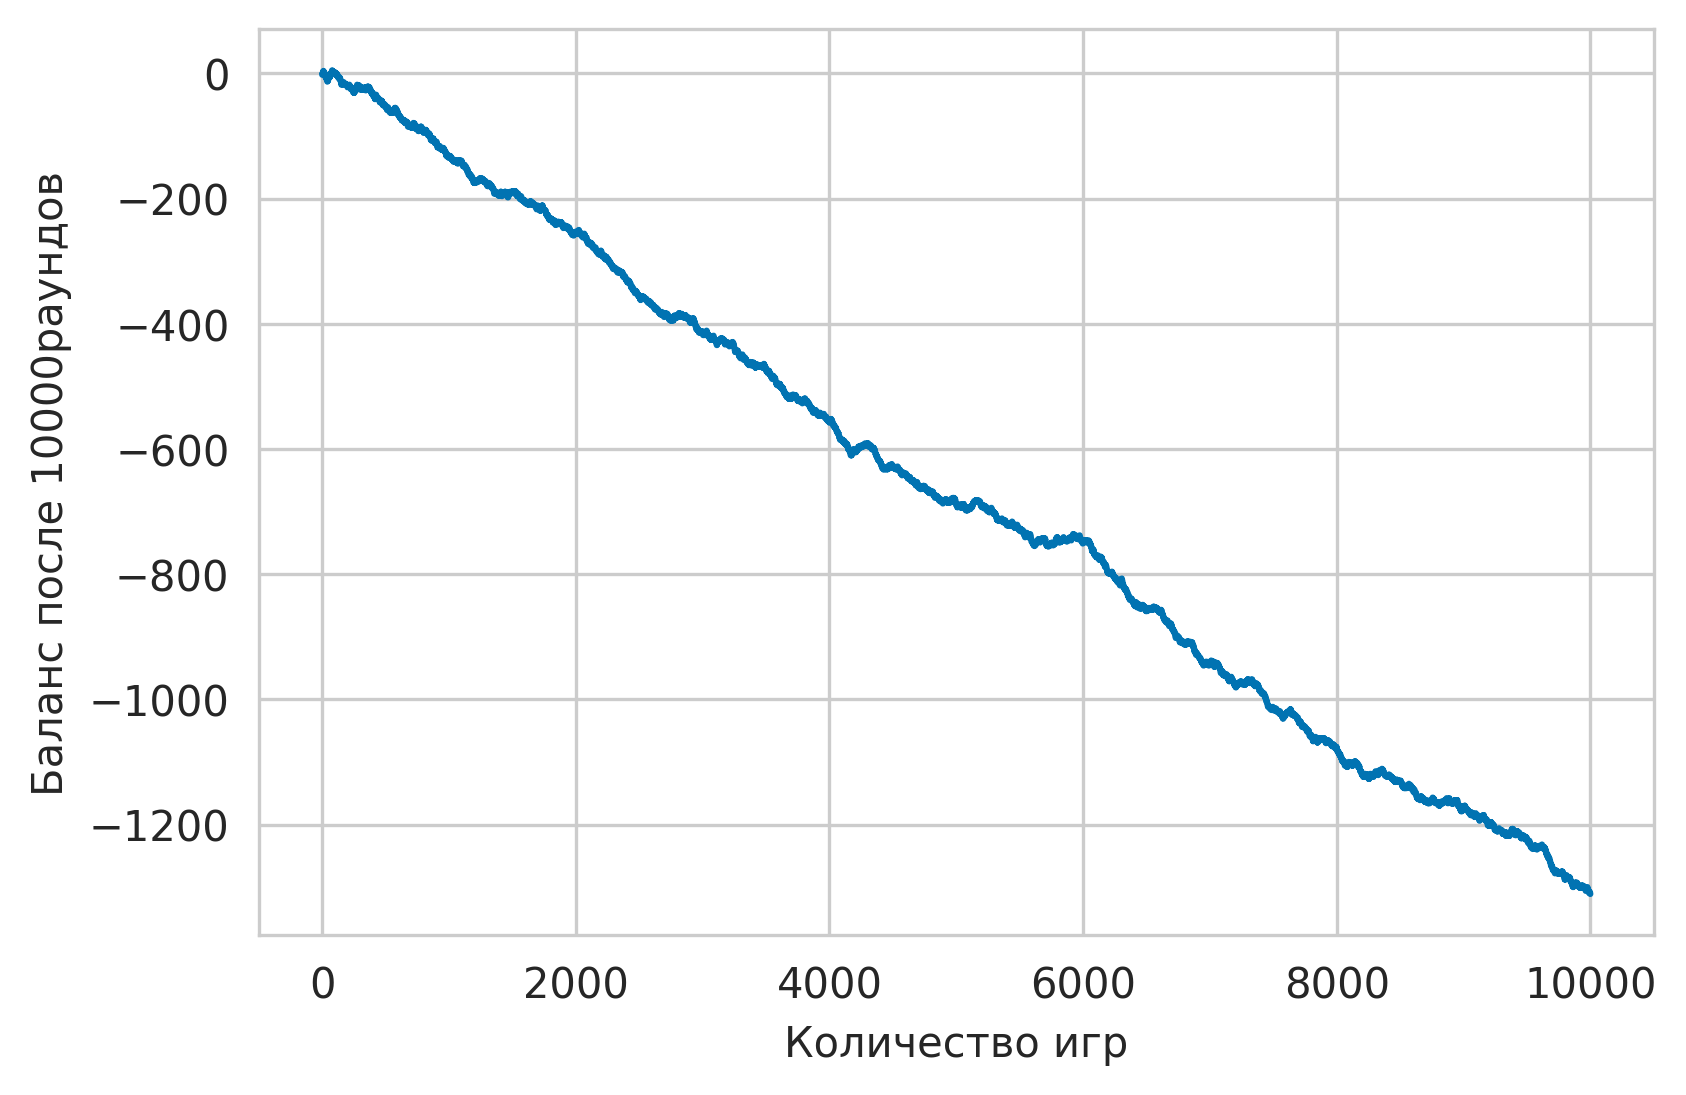

Средний баланс после  10000 раунда игры -1311.0

Средняя награда: -0.066579
Среднее число карт: 2.308600


In [15]:
plt.plot(total_reward)                
plt.xlabel('Количество игр')
plt.ylabel('Баланс после ' + str(num_experiments) + 'раундов')
plt.show()    
print ("Средний баланс после  {} раунда игры {}".format(num_experiments, total_reward[num_experiments-1]))

bj.close()

print("\nСредняя награда: %.6f\nСреднее число карт: %.6f" % (np.mean(total_reward)/num_experiments, np.mean(num_steps)))